# ScmRun
This notebooks describes the new functionality associated with the `ScmRun` class compared to `ScmDataFrame`. This class is tipped to be eventually replace the `ScmDataFrame` as it provides better performance when dealing with a large number of time-series.

These performance improvements are due to a change in how the time-series are stored and accessed. `ScmDataFrame` stored all of the time series data in a single pandas dataframe and all the metadata in another separate dataframe. Operations on the data required complicated joins between the two tables to ensure that they both remained in sync. This resulted in complicated code and limiations around what metadata was stored.

Our usage patterns for `ScmDataFrame` often involved many filtering or group operations. This data structure was no

`ScmRun` is a container for `TimeSeries` data. Filtering by metadata becomes returning a new `ScmRun` object with a different list of `TimeSeries` objects. No more costly recreating of the pandas dataframes on every filter.

In [1]:
# NBVAL_IGNORE_OUTPUT
from scmdata import ScmDataFrame, df_append
from scmdata.run import ScmRun, df_append as run_append
import numpy as np

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
def new_timeseries(
    n=100,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": "World",
            "unit": "K",
            "c": list(range(1, count + 1)),
            **kwargs,
        },
        index=index,
    )

In [3]:
run = new_timeseries(count=3)
run

<scmdata.ScmRun (timeseries: 3, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	     model scenario             variable region unit  c
	0  example   ssp119  Surface Temperature  World    K  1
	1  example   ssp119  Surface Temperature  World    K  2
	2  example   ssp119  Surface Temperature  World    K  3

In [4]:
df = new_timeseries(cls=ScmDataFrame)
df

### Appending performance

In [5]:
# NBVAL_SKIP
dfs = [new_timeseries(cls=ScmDataFrame, run_id=i) for i in range(1000)]

%timeit df_append(dfs)

4.3 s ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# NBVAL_SKIP
runs = [new_timeseries(run_id=i) for i in range(1000)]

%timeit run_append(runs)

10 ms ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Filtering Performance

In [7]:
# results are Scmdataframe and then scmrun for each data point
for count in [1, 10, 100]:
    for n_runs in [1, 10, 100]:
        print("Count {} N_runs {}".format(count, n_runs))
        
        dfs = df_append([new_timeseries(cls=ScmDataFrame, run_id=i, count=count) for i in range(n_runs)])
        runs = run_append([new_timeseries(run_id=i, count=count) for i in range(n_runs)])

        %timeit dfs.filter(c=1)
        %timeit runs.filter(c=1)
        print()

Count 1 N_runs 1
3.26 ms ± 12.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
460 µs ± 1.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Count 1 N_runs 10
3.32 ms ± 2.73 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
498 µs ± 1.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Count 1 N_runs 100
3.67 ms ± 5.75 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
797 µs ± 2.41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Count 10 N_runs 1
3.28 ms ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
500 µs ± 5.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Count 10 N_runs 10
3.6 ms ± 5.53 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
805 µs ± 4.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Count 10 N_runs 100
6.84 ms ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.89 ms ± 90.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Count 100 N_runs 1
3

## Other Features

The filtered run is now a "view" to the data. Changing the metadata or values of the filtered run will change the original.

In [8]:
runs = new_timeseries(count=3)
runs.filter(c=2)["extra"] = "test"
runs

<scmdata.ScmRun (timeseries: 3, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	         model scenario             variable region unit  c extra
	13324  example   ssp119  Surface Temperature  World    K  1   NaN
	13325  example   ssp119  Surface Temperature  World    K  2  test
	13326  example   ssp119  Surface Temperature  World    K  3   NaN

`ScmRun` also has a groupby command to make it easy to iterate over groups.

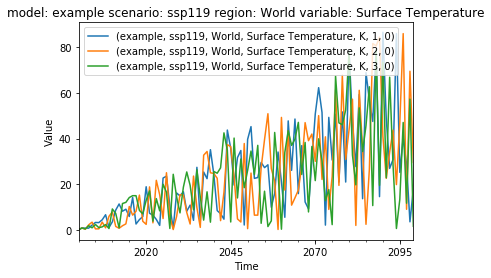

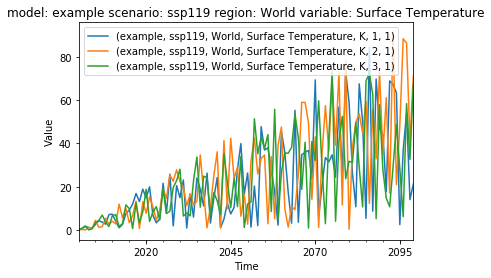

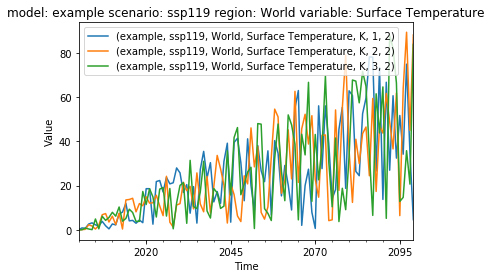

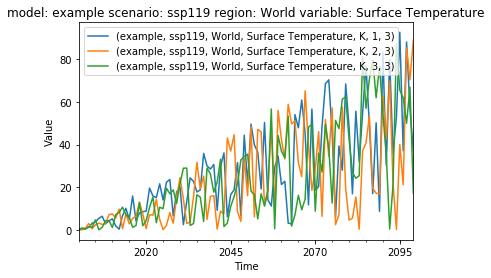

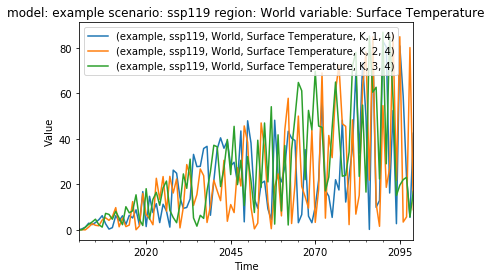

In [9]:
runs = run_append([new_timeseries(run_id=i, count=3) for i in range(5)])
for group in runs.groupby("run_id"):
    group.line_plot()

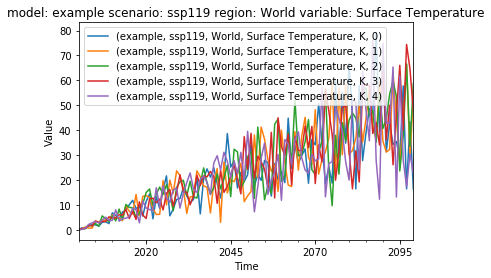

In [10]:
# Aggregate by run_id
runs.groupby("run_id").mean(axis=0).line_plot()

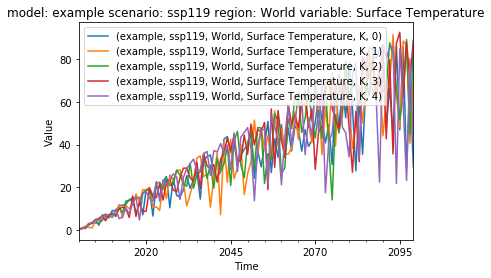

In [11]:
runs.groupby("run_id").max(axis=0).line_plot()